## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Importing Libraries</p>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import mode
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, classification_report, 
    confusion_matrix, accuracy_score, matthews_corrcoef, f1_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedShuffleSplit,
    StratifiedKFold, train_test_split, cross_val_score, cross_validate
)
import warnings
warnings.filterwarnings('ignore')

  ### <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Loading data</p>

In [2]:
cd /workspace/data/

/workspace/data


In [3]:
train_data = pd.read_csv(os.path.join(os.getcwd(), "kaggle/playground-series-s4e8/train.csv"))
test_data = pd.read_csv(os.path.join(os.getcwd(), "kaggle/playground-series-s4e8/test.csv"))
sample_submission_data = pd.read_csv(os.path.join(os.getcwd(), "kaggle/playground-series-s4e8/sample_submission.csv"))

print("train_data :", train_data.shape)
print("test_data :", test_data.shape)
print("sample_submission_data :", sample_submission_data.shape)

train_data : (3116945, 22)
test_data : (2077964, 21)
sample_submission_data : (2077964, 2)


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Basic Info about Data</p> 

In [4]:
train_data.head(2)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w


In [5]:
test_data.head(2)

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a


In [6]:
sample_submission_data.head(2)

,id,class
0,3116945,e
1,3116946,e


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [8]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3116945.0,1.558472e+06,899784.661737,0.00,779236.00,1558472.00,2337708.00,3116944.00
cap-diameter,3116941.0,6.309848e+00,4.657931,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.348333e+00,2.699755,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,1.115379e+01,8.095477,0.00,4.97,9.65,15.63,102.90


class
p    1705396
e    1411549
Name: count, dtype: int64
class
p    0.547137
e    0.452863
Name: count, dtype: float64


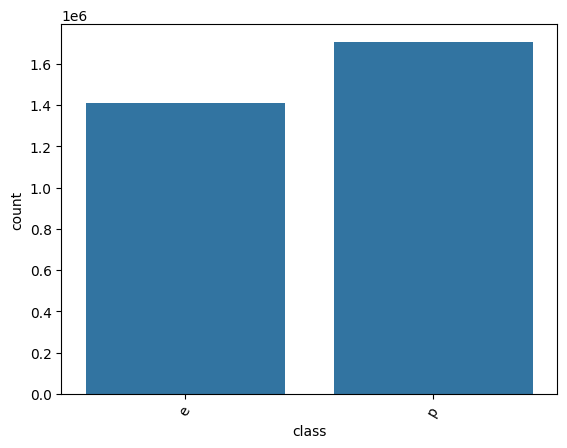

In [9]:
print(train_data['class'].value_counts())
print(train_data['class'].value_counts() / sum(train_data['class'].value_counts()))
sns.countplot(x='class',data=train_data)
plt.xticks(rotation=60)
plt.show()

In [10]:
pd.DataFrame({
    'column': train_data.columns,
    'null-count': train_data.isna().sum().values,
    '% null-count': np.round(train_data.isna().sum().values*100/len(train_data),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count
0,veil-type,2957493,94.884350
1,spore-print-color,2849682,91.425482
2,stem-root,2757023,88.452732
3,veil-color,2740947,87.936970
4,stem-surface,1980861,63.551362
5,gill-spacing,1258435,40.373988
6,cap-surface,671023,21.528227
7,gill-attachment,523936,16.809280
8,ring-type,128880,4.134818
9,gill-color,57,0.001829


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Correlation Matrics</p> 

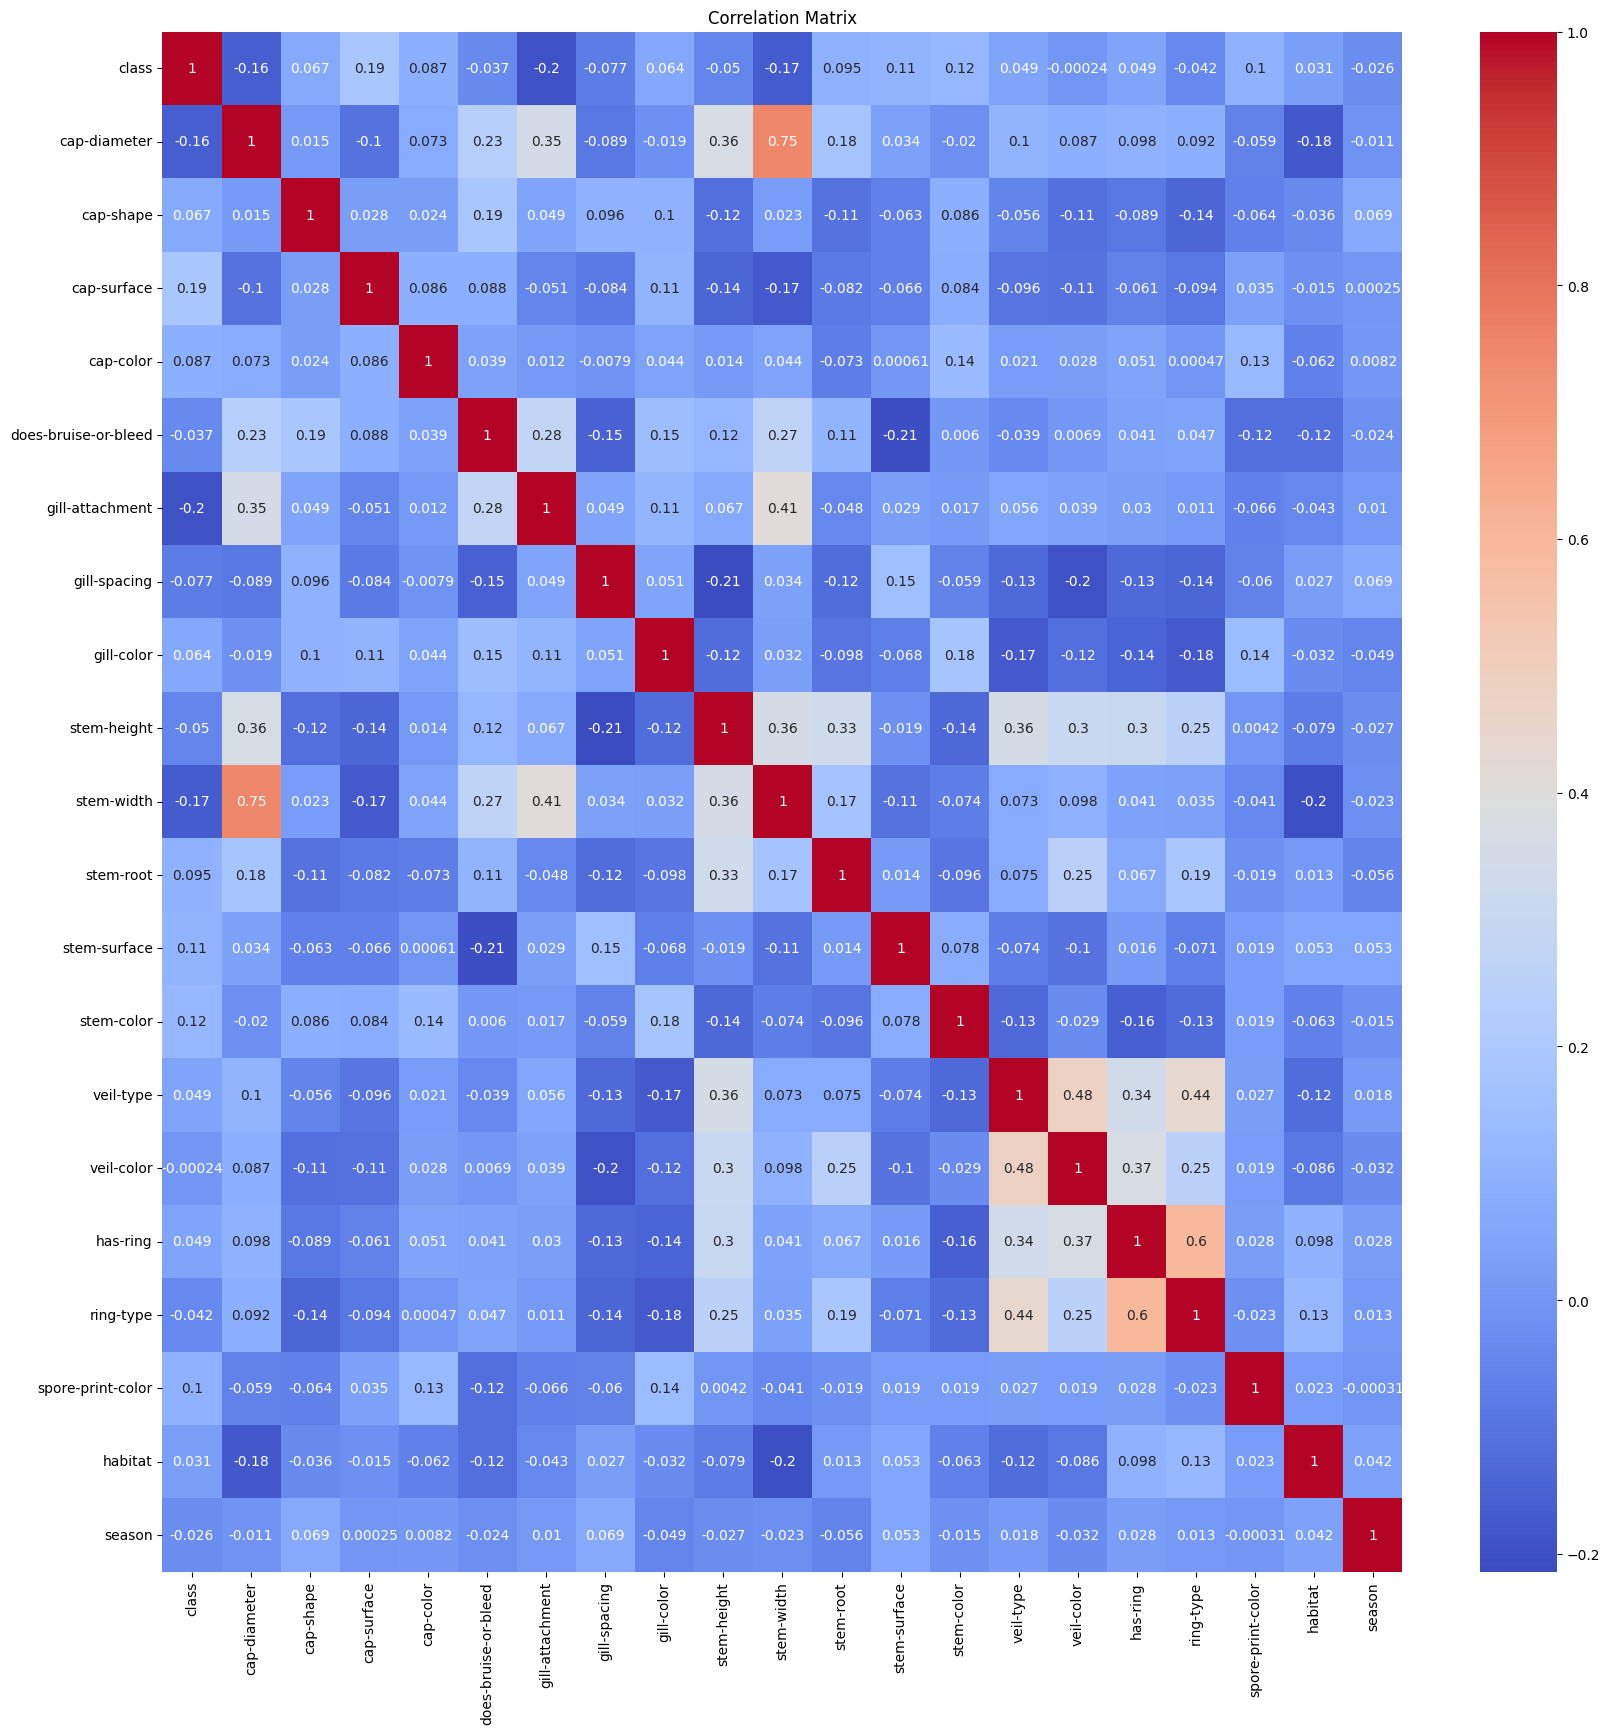

In [11]:
# train_data.replace(['NaN', 'None', 'null', ''], np.nan, inplace=True)
df_dropped = train_data.drop('id', axis=1)
df_encoded = df_dropped.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)
train_data.isna().sum()

correlation_matrix = df_encoded.corr()

correlation_matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Checking Unique Categories
</p> 

In [12]:
# cate_col = train_data.select_dtypes(include=['object']).columns

# # Find unique categories and their counts for each categorical column
# unique_categories = {col: train_data[col].value_counts() for col in cate_col}

# # Set the size of the overall figure
# plt.figure(figsize=(15, len(cate_col) * 5))

# # Plot the count of each unique category
# for i, (col, counts) in enumerate(unique_categories.items(), 1):
#     plt.subplot(len(cate_col), 1, i)
#     sns.barplot(x=counts.index, y=counts.values, palette="viridis")
#     plt.title(f"Count of unique categories in column '{col}'")
#     plt.xlabel('Categories')
#     plt.ylabel('Count')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()

# plt.show()


  ### <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Percentage of Missing Values by Feature</p>

In [13]:
pd.DataFrame({
    'column': train_data.drop('id', axis=1).columns,
    'null-count': train_data.drop('id', axis=1).isna().sum().values,
    '% null-count': np.round(train_data.drop('id', axis=1).isna().sum().values*100/len(train_data.drop('id', axis=1)),6),
    'test null-count': test_data.isna().sum().values,
    '% test null-count': np.round(test_data.isna().sum().values*100/len(test_data),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count,test null-count,% test null-count
0,veil-type,2957493,94.884350,1971545,94.878689
1,spore-print-color,2849682,91.425482,1899617,91.417224
2,stem-root,2757023,88.452732,1838012,88.452543
3,veil-color,2740947,87.936970,1826124,87.880445
4,stem-surface,1980861,63.551362,1321488,63.595327
5,gill-spacing,1258435,40.373988,839595,40.404694
6,cap-surface,671023,21.528227,446904,21.506821
7,gill-attachment,523936,16.809280,349821,16.834796
8,ring-type,128880,4.134818,86195,4.148051
9,gill-color,57,0.001829,49,0.002358


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Checking Feature Importance and Dropping Useless Columns
</p> 

In [14]:
# alpha = 0.05
# values = {}

# for col in train_data.columns:
#     if col == "class":
#         continue

#     A, B = train_data[col], train_data["class"]

#     dfObserved = pd.crosstab(A, B) 
#     chi2, p, dof, expected = scipy.stats.chi2_contingency(dfObserved.values) # 카이제곱 독립 검정 수행
#     values[col] = p
#     if p < alpha:
#         # Reject null hypothesis
#         print("{} is important. (p = {})".format(col, p))
#     else:
#         # Accept null hypothesis
#         print("{} is NOT important. (p = {})".format(col, p))

In [15]:
# Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
#        'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
#        'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
#        'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
#        'habitat', 'season', 'veil-info'],
#       dtype='object')

# 결측치와 특성 존재 여부를 동시에 다룰 수 있음: 앞에서 0과 1로 veil-type의 존재 여부를 표현하고, 뒤에서 'unknown'을 통해 veil-color의 결측치를 처리함으로써 두 정보를 효과적으로 결합할 수 있습니다.
# 모델 학습에 유용한 정보 제공: 결측치나 특성의 존재 여부를 단순히 무시하지 않고, 이들을 결합하여 모델이 더 많은 패턴을 학습할 수 있게 도와줍니다.
# Index(['w', 'y', 'n', 'u', 'k', 'e', 'g', 'p', 'r', 'o', 's', 'a', 't', 'd',
#        'i', 'h', 'c', 'f', 'l', 'b', 'z', '8.25', '2.49', '3.32'],
#       dtype='object', name='veil-color')
# Index(['u', 'w', 'a', 'f', 'e', 'b', 'c', 'y', 'k', 'g', 'n', 's', 'r', 'd',
#        'p', 'h', 'i', 'l', 'is None', 't', '21.11', '5.94'],
#       dtype='object', name='veil-type')

# Index(['f10', 'tnone', 't1', 't7', 't10', 't4', 't2', 't5', 't3', 't9',
#        'fnone', 'f1', 'f2', 'f7', 'f4', 't8', 'f5', 'r2', 't6', 'f3', 'l4',
#        't0', 'p5', 'z7', 'c10', 'x10', 'f9', 'f6', 's10', 'm9', 'hnone', 's1',
#        'g3', 'g5', 'h7', 'e1', 'f0', 'r4', 'dnone', 's5', 'cnone', 'h1', 'p1',
#        'h5', 'h10', 'w3', 'y2', 'a10', 'ynone', 'e10', 'p7', '10.310', 's2',
#        'o2', 'g10', 'h2', 'g1', 's3', 'p3', 'knone', 'inone', 'nnone', 'rnone',
#        'l5', 'c1', 'n10', 'c3', 'o10', 'e4', 'd10', 'f has-ring10', 'lnone',
#        'c7', 'e3', 'y1', 'k10'],
#       dtype='object', name='has-ring-type')

train_data['veil-info'] = train_data['veil-type'].notna().astype(int).astype(str) + train_data['veil-color'].fillna('unknown')
cap_shape_mapping = {'b': 0, 'c': 1, 'x': 2, 'f': 3, 's': 4, 'p': 5, 'o': 6}
cap_color_mapping = {'n': 0, 'b': 1, 'g': 2, 'r': 3, 'p': 4, 'u': 5, 'e': 6, 'w': 7, 'y': 8, 'l': 9, 'o': 10, 'k': 11}
ring_type_mapping = {'c': 0, 'e': 1, 'r': 2, 'g': 3, 'l': 4, 'p': 5, 's': 6, 'z': 7, 'y': 8, 'm': 9, 'f': 10}
train_data['cap-shape'] = train_data['cap-shape'].map(cap_shape_mapping).astype(str).str.replace('.0', '', regex=False)
train_data['cap-color'] = train_data['cap-color'].map(cap_color_mapping).astype(str).str.replace('.0', '', regex=False)
train_data['has-ring-type'] = (
    train_data['has-ring'] + 
    train_data['ring-type'].fillna('none').map(ring_type_mapping).apply(lambda x: f"{x:.0f}" if pd.notna(x) else 'none').str.replace('.0', '', regex=False)
)

test_data['veil-info'] = test_data['veil-type'].notna().astype(int).astype(str) + test_data['veil-color'].fillna('unknown')
test_data['cap-shape'] = test_data['cap-shape'].map(cap_shape_mapping).astype(str).str.replace('.0', '', regex=False)
test_data['cap-color'] = test_data['cap-color'].map(cap_color_mapping).astype(str).str.replace('.0', '', regex=False)
test_data['has-ring-type'] = (
    test_data['has-ring'] + 
    test_data['ring-type'].fillna('none').map(ring_type_mapping).apply(lambda x: f"{x:.0f}" if pd.notna(x) else 'none').str.replace('.0', '', regex=False)
)

In [16]:
train_data['has-ring-type']

0          f10
1           t7
2          f10
3          f10
4          f10
          ... 
3116940     t3
3116941    f10
3116942     t7
3116943     t5
3116944    f10
Name: has-ring-type, Length: 3116945, dtype: object

In [17]:
set(train_data['veil-info'])

{'02.49',
 '03.32',
 '08.25',
 '0a',
 '0b',
 '0c',
 '0d',
 '0e',
 '0f',
 '0g',
 '0h',
 '0i',
 '0k',
 '0l',
 '0n',
 '0o',
 '0p',
 '0r',
 '0s',
 '0t',
 '0u',
 '0unknown',
 '0w',
 '0y',
 '1g',
 '1h',
 '1k',
 '1n',
 '1r',
 '1t',
 '1u',
 '1unknown',
 '1w',
 '1y',
 '1z'}

In [18]:
train_data = train_data.drop(['id', 'veil-color', 'veil-type', 'has-ring', 'ring-type'], axis=1)
test_data = test_data.drop(['id', 'veil-color', 'veil-type', 'has-ring', 'ring-type'], axis=1)

In [19]:
df_encoded = train_data
dt_encoded = test_data

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Handling NaN Values And Less Frequent Categories</p> 

In [21]:
columns_to_fill_train = train_data.columns[(train_data.isna().sum() > 0) & (train_data.isna().sum() < 60)].tolist()
columns_to_fill_test = test_data.columns[(test_data.isna().sum() > 0) & (test_data.isna().sum() < 100)].tolist()

corr_matrix_train = df_encoded.corr()
corr_matrix_test = dt_encoded.corr()

def fill_missing_values(data, columns_to_fill, corr_matrix):
    for column in columns_to_fill:
        if column in corr_matrix.columns:
            most_corr_features = corr_matrix[column][corr_matrix[column].abs() > 0.1].index.tolist()
            if column in most_corr_features:
                most_corr_features.remove(column)

            if most_corr_features:
                group_modes = data.groupby(most_corr_features)[column].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

                def fill_na(row):
                    if pd.isna(row[column]):
                        try:
                            return group_modes.loc[tuple(row[most_corr_features])]
                        except KeyError:
                            return np.nan
                    else:
                        return row[column]

                data[column] = data.apply(fill_na, axis=1)

fill_missing_values(df_encoded, columns_to_fill_train, corr_matrix_train)
fill_missing_values(dt_encoded, columns_to_fill_test, corr_matrix_test)


In [22]:
train_data.isna().sum()

class                         0
cap-diameter                  4
cap-shape                     0
cap-surface              671023
cap-color                     0
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
spore-print-color       2849682
habitat                      45
season                        0
veil-info                     0
has-ring-type                24
dtype: int64

In [23]:
train_data.columns[(train_data.isna().sum() > 0) & (train_data.isna().sum() < 60)].tolist()

['cap-diameter',
 'does-bruise-or-bleed',
 'gill-color',
 'stem-color',
 'habitat',
 'has-ring-type']

In [24]:
def cleaning(df):
    threshold = 100
    
    cat_feats = ['cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'spore-print-color',
       'habitat', 'season', 'veil-info', 'has-ring-type']
    
    for feat in cat_feats:
        if df[feat].dtype.name == 'category':
            # Add 'missing' and 'noise' to categories if not present
            if 'missing' not in df[feat].cat.categories:
                df[feat] = df[feat].cat.add_categories('missing')
            if 'noise' not in df[feat].cat.categories:
                df[feat] = df[feat].cat.add_categories('noise')
        else:
            # Convert to category and add new categories
            df[feat] = df[feat].astype('category')
            df[feat] = df[feat].cat.add_categories(['missing', 'noise'])
        
        # Fill missing values with 'missing'
        df[feat] = df[feat].fillna('missing')
        
        # Replace infrequent categories with 'noise'
        counts = df[feat].value_counts(dropna=False)
        infrequent_categories = counts[counts < threshold].index
        df[feat] = df[feat].apply(lambda x: 'missing' if x in infrequent_categories else x)
    
    return df

# Example usage
train_data = cleaning(train_data)
test_data = cleaning(test_data)

In [25]:
train_data.isna().sum()

class                   0
cap-diameter            4
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
spore-print-color       0
habitat                 0
season                  0
veil-info               0
has-ring-type           0
dtype: int64

In [26]:
group_by_features = ['stem-width', 'stem-height']
group_means_train = train_data.groupby(group_by_features)['cap-diameter'].mean()
group_means_train

stem-width  stem-height
0.00        0.00            4.253239
            2.69            3.900000
            2.85            3.040000
            2.93            2.810000
            2.94            2.840000
                             ...    
102.48      26.04           9.910000
            26.38          20.490000
            26.40          27.080000
            26.44          23.710000
102.90      27.32          17.570000
Name: cap-diameter, Length: 1134552, dtype: float64

In [27]:
group_by_features = ['stem-width', 'stem-height']
group_means_train = train_data.groupby(group_by_features)['cap-diameter'].mean()

def fill_na_with_group_mean(row):
    if pd.isna(row['cap-diameter']):
        group = tuple(row[group_by_features])
        return group_means_train.get(group, np.nan) 
    else:
        return row['cap-diameter']

train_data['cap-diameter'] = train_data.apply(fill_na_with_group_mean, axis=1)
test_data['cap-diameter'] = test_data.apply(fill_na_with_group_mean, axis=1)

In [28]:
group_by_features = ['stem-width', 'stem-height']

# Calculate group means for the train data
group_means_train = train_data.groupby(group_by_features)['cap-diameter'].mean()

def fill_na_with_group_mean(row, group_means):
    if pd.isna(row['cap-diameter']):
        group = tuple(row[group_by_features])
        return group_means.get(group, np.nan)
    else:
        return row['cap-diameter']

# Apply to train_data using train group means
train_data['cap-diameter'] = train_data.apply(fill_na_with_group_mean, axis=1, group_means=group_means_train)

# Apply the same group means from train_data to test_data
test_data['cap-diameter'] = test_data.apply(fill_na_with_group_mean, axis=1, group_means=group_means_train)
###
###
# Calculate the mode from the training data
cap_diameter_mode = train_data['cap-diameter'].mode()[0]
stem_height_mode = train_data['stem-height'].mode()[0]

# Fill missing values in the training data using the mode calculated from the training data
train_data['cap-diameter'] = train_data['cap-diameter'].fillna(cap_diameter_mode)
train_data['stem-height'] = train_data['stem-height'].fillna(stem_height_mode)

# Fill missing values in the test data using the mode calculated from the training data
test_data['cap-diameter'] = test_data['cap-diameter'].fillna(cap_diameter_mode)
test_data['stem-height'] = test_data['stem-height'].fillna(stem_height_mode)

In [29]:
# print("Nan Values in Train data")
# print(null_percent(train_data))
# print("Nan Values in Test data")
# print(null_percent(test_data))

In [30]:
cat_feats = ['cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'spore-print-color',
       'habitat', 'season', 'veil-info', 'has-ring-type']

for feat in cat_feats:
    train_data[feat] = train_data[feat].astype('category')
for feat in cat_feats:
    test_data[feat] = test_data[feat].astype('category')

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Splitting Data</p> 

In [31]:
X = train_data.drop(['class'], axis=1)
y = train_data['class']
print(X.shape, y.shape)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y[:3])

(3116945, 18) (3116945,)
[0 1 0]


In [32]:
# Callback to print the MCC score for each trial
def print_mcc_callback(study, trial):
    mcc = trial.user_attrs["mcc"]
    print(f"Trial {trial.number}: MCC = {mcc}")

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Using XGBoost with optuna</p> 

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")
    
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=cat_feats,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

In [ ]:
lgb_clf = LGBMClassifier(device='cpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4885)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200), #  100, 1000
        'max_depth': trial.suggest_int('max_depth', 10, 22), #5, 10
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), # 0.5, 1.0
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0),
        "eta": trial.suggest_float("eta", 1e-3, 1e-2),
        "min_child_weight": trial.suggest_int("min_child_weight", 40, 100),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "max_leaves": trial.suggest_int("max_leaves", 40, 100), # 16, 84
        'device': 'cuda',
        'tree_method': 'gpu_hist'
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', enable_categorical=True, early_stopping_rounds=20)
    # Fit the model with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Validation set
        verbose=False                 # Suppress output
    )
    
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc



storage = "sqlite:///xgb.db"

# Optimize hyperparameters with Optuna
study = optuna.create_study(storage=storage,
                            direction='maximize',
                           )
study.optimize(objective, n_trials=100, callbacks=[print_mcc_callback])

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "verbose": False,
        "allow_writing_files": False,
        "task_type": 'GPU',
        "cat_features": cat_feats
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Validation set
        early_stopping_rounds=20,
        verbose=False                 # Suppress output
    )
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc


study_name = "cat"
storage = "sqlite:///cat.db"

study = optuna.create_study(storage=storage,
                            study_name=study_name,
                            direction="maximize",
                            sampler=TPESampler(n_startup_trials=20, multivariate=True),
                            load_if_exists=True)

study.optimize(objective, n_trials=50, callbacks=[print_mcc_callback])

print(study.best_params)

In [ ]:
def objective(trial):
    params = {
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "device": 'cpu',
        "verbosity": -1
    }

    model = LGBMClassifier(**params, early_stopping_rounds=20)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Validation set
        # verbose=False                 # Suppress output
    )
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc


study_name = "lgb"
storage = "sqlite:///lgb.db"

study = optuna.create_study(storage=storage,
                            study_name=study_name,
                            direction="maximize",
                            sampler=TPESampler(n_startup_trials=20, multivariate=True),
                            load_if_exists=True)

study.optimize(objective, n_trials=100, callbacks=[print_mcc_callback])

print(study.best_params)

In [33]:
# parameters={'n_estimators': 297, 'max_depth': 16, 'learning_rate': 0.03906159386409017, 'subsample': 0.6935900010487451, 'colsample_bytree': 0.5171160704967471, 'gamma': 0.00013710778966124443, 'lambda': 0.0017203271581656767, 'alpha': 8.501510750413265e-06, 'scale_pos_weight': 1.0017942891559255,'enable_categorical': True,'tree_method': 'hist', 'device': 'cuda'}

# 0.984876834594928
xgb_parameters={'n_estimators': 629, 'max_depth': 16, 'learning_rate': 0.10540811331505591, 'subsample': 0.9980081491289166, 'colsample_bytree': 0.7065318052513923, 'gamma': 2.8307622020907574e-06, 'lambda': 0.02456026309353021, 'alpha': 1.5584362263554227e-07, 'scale_pos_weight': 1.105994872793953, 'eta': 0.0010400771543147627, 'min_child_weight': 79, 'grow_policy': 'depthwise', 'max_leaves': 61,
               'device': 'cuda'
               }
# 0.98473160011893
cat_parameters={'iterations': 1472, 'learning_rate': 0.08436268683474936, 'depth': 8, 'l2_leaf_reg': 0.2621416701020154, 'bootstrap_type': 'Bayesian', 'random_strength': 4.490114031912514e-07, 'bagging_temperature': 0.42447506181344297, 'od_type': 'Iter', 'od_wait': 21,
                "task_type": 'GPU',
                "cat_features": cat_feats}
# 0.9848032057376603
lgb_parameters={'lambda_l1': 1.3323938321586053e-07, 'lambda_l2': 0.07774032281247541, 'num_leaves': 248, 'feature_fraction': 0.41087472855265783, 'bagging_fraction': 0.9928696340850532, 'bagging_freq': 4, 'min_child_samples': 97} 

In [34]:
def model_trainer(model, X, y, n_splits=5, random_state=4885):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_data))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

In [35]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_parameters, enable_categorical=True), X, y, random_state=4885)
oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_parameters), X, y, random_state=4885)
oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_parameters), X, y, random_state=4885)

Training XGBClassifier
--- Fold 1 MCC Score: 0.984703
--- Fold 2 MCC Score: 0.984683
--- Fold 3 MCC Score: 0.984742
--- Fold 4 MCC Score: 0.984075
--- Fold 5 MCC Score: 0.984694

---> Mean MCC Score: 0.984579 ± 0.000253


Training CatBoostClassifier
0:	learn: 0.6011092	total: 77.3ms	remaining: 1m 53s
1:	learn: 0.5157253	total: 160ms	remaining: 1m 57s
2:	learn: 0.4469501	total: 227ms	remaining: 1m 51s
3:	learn: 0.3919998	total: 299ms	remaining: 1m 49s
4:	learn: 0.3465939	total: 370ms	remaining: 1m 48s
5:	learn: 0.3169361	total: 425ms	remaining: 1m 43s
6:	learn: 0.2809067	total: 495ms	remaining: 1m 43s
7:	learn: 0.2488664	total: 567ms	remaining: 1m 43s
8:	learn: 0.2369448	total: 631ms	remaining: 1m 42s
9:	learn: 0.2147048	total: 702ms	remaining: 1m 42s
10:	learn: 0.1940737	total: 776ms	remaining: 1m 43s
11:	learn: 0.1852591	total: 851ms	remaining: 1m 43s
12:	learn: 0.1760762	total: 905ms	remaining: 1m 41s
13:	learn: 0.1617248	total: 988ms	remaining: 1m 42s
14:	learn: 0.1515820	total: 1.0

In [57]:
xgb_probs = np.mean(oof_probs['xgb'], axis=0)[:, 1]
cat_probs = np.mean(oof_probs['cat'], axis=0)[:, 1]
lgb_probs = np.mean(oof_probs['lgb'], axis=0)[:, 1]

In [58]:
xgb_probs[0]

0.00486417

In [59]:
# Average the probabilities for class 1 from the three models
average_probs = np.mean([xgb_probs, cat_probs, lgb_probs], axis=0)

In [61]:
# _0.98508
# Average the probabilities for class 1 from the three models
average_probs = np.mean([xgb_probs, cat_probs, lgb_probs], axis=0)

# Assuming you have the 'id' column from the test data
id_column = sample_submission_data.pop('id')

# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    'id': id_column,
    'class': average_probs
})
# Save the submission DataFrame to a CSV file
submission_df.to_csv('./kaggle/submission_xgb_cat_lgbm_0830_0.98508_prob.csv', index=False)
print("Submission file created: submission_autog_ensemble_avg.csv")

Submission file created: submission_autog_ensemble_avg.csv


# 예측값으로 저장하는법

In [36]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

In [ ]:
np.argmax(np.mean(oof_probs['xgb'], axis=0), axis=1)[0]

In [62]:
oof_preds['cat']

array([0, 1, 1, ..., 1, 0, 0])

In [69]:
sub = pd.read_csv("./kaggle/playground-series-s4e8/sample_submission.csv")
preds = oof_preds['lgb']
sub['class'] = label_encoder.inverse_transform(preds)
sub.to_csv('./kaggle/playground-series-s4e8/submission_lgb_0830_111.csv', index=False)

In [38]:
# sub = pd.read_csv("./kaggle/playground-series-s4e8/sample_submission.csv")
# preds = [pred for model, pred in oof_preds.items()]
# md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
# sub['class'] = label_encoder.inverse_transform(md)
# sub.to_csv('./kaggle/playground-series-s4e8/submission_xgb_cat_lgbm_0830_111.csv', index=False)